In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import requests
import folium
import warnings
warnings.filterwarnings('ignore')
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
py.init_notebook_mode(connected=True)
import folium
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

In [2]:

data_json = requests.get('https://api.rootnet.in/covid19-in/unofficial/covid19india.org/').json()
covid19 = pd.read_csv('../input/covid19-in-india/covid_19_india.csv')
patientDetail = pd.read_csv('../input/covid19-in-india/IndividualDetails.csv')

df_data = pd.json_normalize(data_json['data']['rawPatientData'])
df_data.drop(df_data.iloc[:, -5:], inplace = True, axis = 1) 
df_data.drop(['onsetEstimate'], axis=1,inplace = True)

In [3]:
# Search for the Indian state for analysis from these options:
df_data.state.value_counts().index

Index(['Maharashtra', 'Gujarat', 'Delhi', 'Rajasthan', 'Madhya Pradesh',
       'Tamil Nadu', 'Uttar Pradesh', 'Andhra Pradesh', 'Telangana',
       'West Bengal', 'Jammu and Kashmir', 'Karnataka', 'Kerala', 'Punjab',
       'Haryana', 'Bihar', 'Odisha', 'Jharkhand', 'Uttarakhand',
       'Himachal Pradesh', 'Chhattisgarh', 'Assam', 'Chandigarh',
       'Andaman and Nicobar Islands', 'Ladakh', 'Meghalaya', 'Puducherry',
       'Goa', 'Tripura', 'Manipur', 'Mizoram', 'Arunachal Pradesh', ''],
      dtype='object')

In [4]:
state = 'Kerala'

In [5]:
df_data_state = df_data[df_data['state'] == state]
df_data_state.index = np.arange(1,len(df_data_state)+1)
df_data_state

,patientId,reportedOn,ageEstimate,gender,city,district,state,status,notes
1,1,30/01/2020,20,female,Thrissur,Thrissur,Kerala,Recovered,Travelled from Wuhan
2,2,02/02/2020,,,Alappuzha,Alappuzha,Kerala,Recovered,Travelled from Wuhan
3,3,03/02/2020,,,Kasaragod,Kasaragod,Kerala,Recovered,Travelled from Wuhan
4,35,08/03/2020,24,male,Ranni,Pathanamthitta,Kerala,Recovered,Travelled from Italy on 29/02/2020 through Doha
5,36,08/03/2020,54,male,Ranni,Pathanamthitta,Kerala,Recovered,Travelled from Italy on 29/02/2020 through Doha
...,...,...,...,...,...,...,...,...,...
465,26526,26/04/2020,,,,Kottayam,Kerala,Hospitalized,Details awaited
466,26527,26/04/2020,,,,Kottayam,Kerala,Hospitalized,Details awaited
467,26528,26/04/2020,,,,Kottayam,Kerala,Hospitalized,Details awaited
468,26529,26/04/2020,,,,Kottayam,Kerala,Hospitalized,Details awaited


## Gender Details

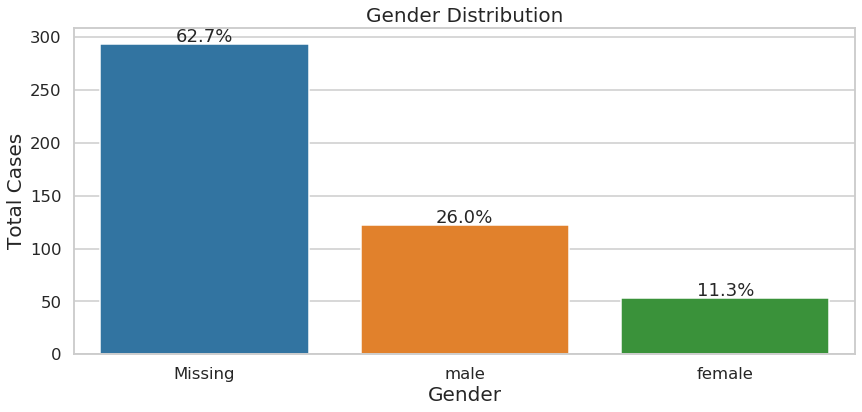

In [6]:
df_data_state['gender'].replace('', np.nan, inplace=True)
df_data_state.gender.fillna('Missing',inplace = True)
sns.color_palette("bright")
plt.figure(figsize=(14,6))
sns.set_style('whitegrid')
sns.set_context("talk")
sns.countplot(data=df_data_state,x='gender',order=df_data_state['gender'].value_counts().index)
plt.title('Gender Distribution', fontsize = 20)
plt.xlabel('Gender', fontsize = 20)
plt.ylabel('Total Cases', fontsize = 20)
order2 = df_data_state['gender'].value_counts()

for i in range(order2.shape[0]):
    count = order2[i]
    strt='{:0.1f}%'.format(100*count / df_data_state.gender.dropna().count() )
    plt.text(i,count+2,strt,ha='center')

## Age Group Analysis

In [7]:
df_data_state['ageEstimate'].replace('', np.nan, inplace=True)
df_data_state.ageEstimate.fillna(-1,inplace = True)
df_data_state['ageEstimate'] = pd.cut(x=df_data_state['ageEstimate'].astype(float), bins=[0, 10, 20, 30, 40,50,60,70,80,90], labels=['10s', '20s', '30s', '40s','50s','60s','70s','80s','90s'])
df_data_state['ageEstimate'] = df_data_state['ageEstimate'].cat.add_categories('Missing')
df_data_state.ageEstimate.fillna('Missing',inplace = True)

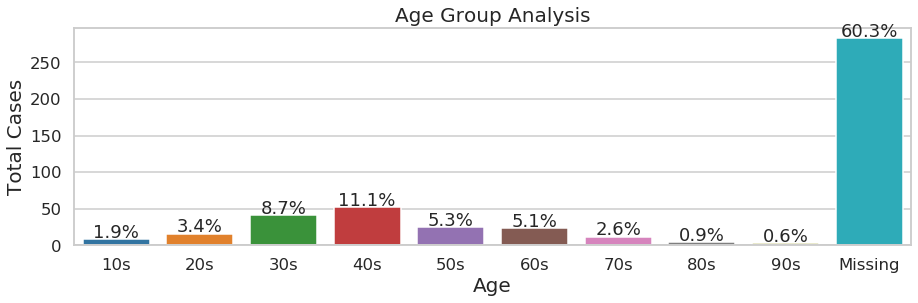

In [8]:

sns.color_palette("deep")
plt.figure(figsize=(15,4))
sns.countplot(data=df_data_state,x='ageEstimate',order=df_data_state['ageEstimate'].value_counts(sort=False).index)
plt.title('Age Group Analysis', fontsize = 20)
plt.xlabel('Age', fontsize = 20)
plt.ylabel('Total Cases', fontsize = 20)
order2 = df_data_state['ageEstimate'].value_counts()

for i in range(order2.shape[0]):
    count = order2[i]
    strt='{:0.1f}%'.format(100*count / df_data_state.ageEstimate.dropna().count() )
    plt.text(i,count+2,strt,ha='center')

##                        District wise Analysis


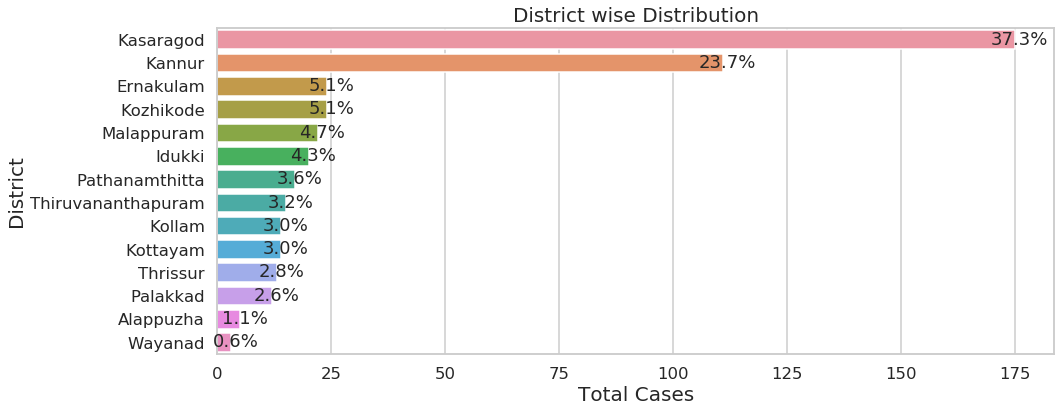

In [9]:
num_of_dist = 15


df_data_state['district'].replace('', np.nan, inplace=True)
df3=df_data_state.groupby(['district']).count()
df3.reset_index(inplace=True)
plt.figure(figsize=(15,6))
df4=df3.sort_values('patientId',ascending=False)
df4=df4.head(num_of_dist)
ax = sns.barplot(data=df4,x='patientId',y='district')
plt.title('District wise Distribution',fontsize = 20)
plt.ylabel('District',fontsize = 20 )
plt.xlabel('Total Cases',fontsize = 20)

order2 = df_data_state['district'].value_counts()
order2 = order2.head(num_of_dist)

total = df_data_state.district.dropna().count() 
for p in ax.patches:
    width = p.get_width()
    ax.text(p.get_x()+p.get_width()+1,
             p.get_y() +0.6,
            '{:1.1f}%'.format(100*width/total),
            ha="center") 
plt.show()

## Timeline

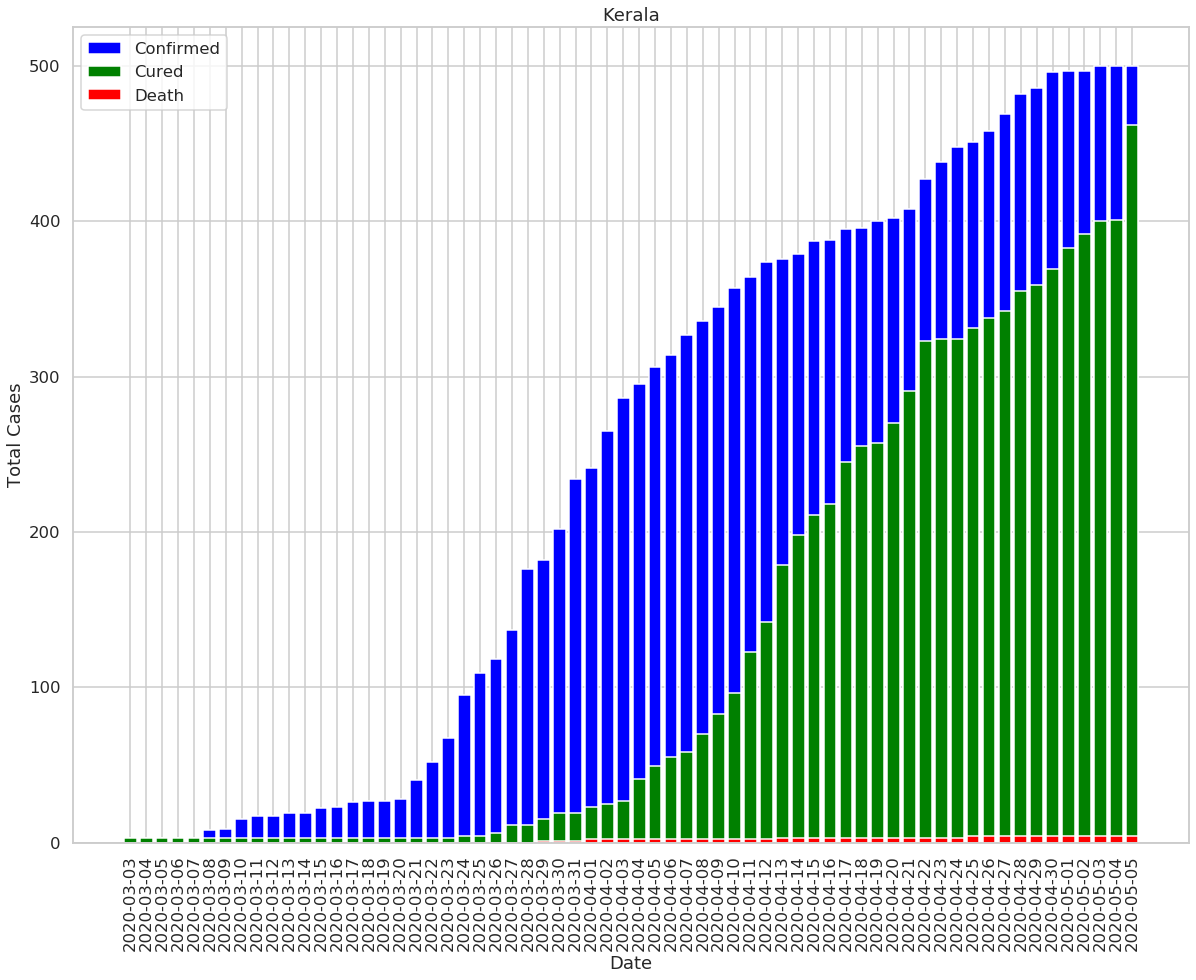

In [10]:
covid19['Date'] = pd.to_datetime(covid19['Date'],dayfirst=True)
covid = covid19[covid19['Date']>'2020-03-02']
covid.reset_index(inplace=True)
df5=covid.groupby(['Date','State/UnionTerritory']).sum()
df5.reset_index(inplace=True)
df5['Date'] = df5['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))

plt.figure(figsize=(20,15))

df4=df5[df5['State/UnionTerritory']== state ]
plt.bar(df4.Date,df4.Confirmed,label='Confirmed', color='Blue')
plt.bar(df4.Date,df4.Cured,label='Cured',color='Green')
plt.bar(df4.Date,df4.Deaths,label='Death', color='Red')
plt.xticks(rotation=90)
plt.title(state)
plt.ylabel('Total Cases')
plt.xlabel('Date')
plt.legend()
plt.show()

In [11]:
# Adding Location data (Latitude,Longitude)
locations = {
    "Kerala" : [10.8505,76.2711],
    "Maharashtra" : [19.7515,75.7139],
    "Karnataka": [15.3173,75.7139],
    "Telangana": [18.1124,79.0193],
    "Uttar Pradesh": [26.8467,80.9462],
    "Rajasthan": [27.0238,74.2179],
    "Gujarat":[22.2587,71.1924],
    "Delhi" : [28.7041,77.1025],
    "Punjab":[31.1471,75.3412],
    "Tamil Nadu": [11.1271,78.6569],
    "Haryana": [29.0588,76.0856],
    "Madhya Pradesh":[22.9734,78.6569],
    "Jammu and Kashmir":[33.7782,76.5762],
    "Ladakh": [34.1526,77.5770],
    "Andhra Pradesh":[15.9129,79.7400],
    "West Bengal": [22.9868,87.8550],
    "Bihar": [25.0961,85.3131],
    "Chhattisgarh":[21.2787,81.8661],
    "Chandigarh":[30.7333,76.7794],
    "Uttarakhand":[30.0668,79.0193],
    "Himachal Pradesh":[31.1048,77.1734],
    "Goa": [15.2993,74.1240],
    "Odisha":[20.9517,85.0985],
    "Andaman and Nicobar Islands": [11.7401,92.6586],
    "Puducherry":[11.9416,79.8083],
    "Manipur":[24.6637,93.9063],
    "Mizoram":[23.1645,92.9376],
    "Assam":[26.2006,92.9376],
    "Meghalaya":[25.4670,91.3662],
    "Tripura":[23.9408,91.9882],
    "Arunachal Pradesh":[28.2180,94.7278],
    "Jharkhand" : [23.6102,85.2799],
    "Nagaland": [26.1584,94.5624],
    "Sikkim": [27.5330,88.5122],
    "Dadra and Nagar Haveli":[20.1809,73.0169],
    "Lakshadweep":[10.5667,72.6417],
    "Daman and Diu":[20.4283,72.8397]    
}

In [12]:
geojsonData = requests.get('https://raw.githubusercontent.com/geohacker/india/master/district/india_district.geojson').json()
for i in geojsonData['features']:
    i['id'] = i['properties']['NAME_2']


## Note:
### The districts shown are according to the 2011 census.

In [13]:

geojsonData_state ={
    "type": "FeatureCollection",
    "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
    "features": {}
}
j=0
array_district = []
for i in geojsonData['features']:
    if(i['properties']['NAME_1'] == state):
        array_district.append(i)
geojsonData_state['features'] = array_district


stateDetail=patientDetail[patientDetail['detected_state']==state]
stateDetail=stateDetail.groupby('detected_district').count()
stateDetail.reset_index(inplace=True)



data = stateDetail

bins = list(data['id'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]))

map_choropleth = folium.Map(location = locations[state], zoom_start = 7 ,max_zoom=10, min_zoom=5)
folium.Choropleth(geo_data=geojsonData_state,
                 data=data,
                 name='CHOROPLETH',
                 key_on='feature.id',
                 columns = ['detected_district','diagnosed_date'],
                 fill_color='BuPu',
                 fill_opacity=0.7,
                 line_opacity=0.8,
                 legend_name='Population',
                 bins=bins,
                 highlight=False).add_to(map_choropleth)

folium.LayerControl().add_to(map_choropleth)

map_choropleth